In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')

In [3]:
!pip install langchain sentence-transformers faiss-cpu pypdf transformers torch langchain-community  #instalujemy potrzebne biblioteki
!pip install bitsandbytes accelerate

In [4]:
import os
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline, AutoModelForCausalLM
import torch

# MOŻESZ IMPORTOWAĆ INNE BIBLIOTEKI, ALE PAMIĘTAJ O ICH INSTALACJI W WIERSZU POWYŻEJ !!!

# Asystent AI - PDF RAG
Po dwóch udanych misjach – rozwikłaniu tajemnicy przeżycia na Titanicu i odczytaniu ręcznych notatek o pokojach – myślałeś, że zasłużysz na odpoczynek. Jednak telefon od tajemniczego zleceniodawcy rozbrzmiał ponownie, tym razem z jeszcze pilniejszą sprawą.

"Wasze poprzednie modele były kluczowe," – rozpoczął głos w słuchawce – "ale to dopiero wstęp do prawdziwego wyzwania. Nasi agenci przechwycili poufny szpont dokumentów. To nie są zwykłe papiery; to zestaw od 3 do 5 artykułów naukowych w formacie PDF, które zawierają fragmenty przełomowych badań. Informacje są niekompletne, celowo pomieszane i zaszyfrowane."

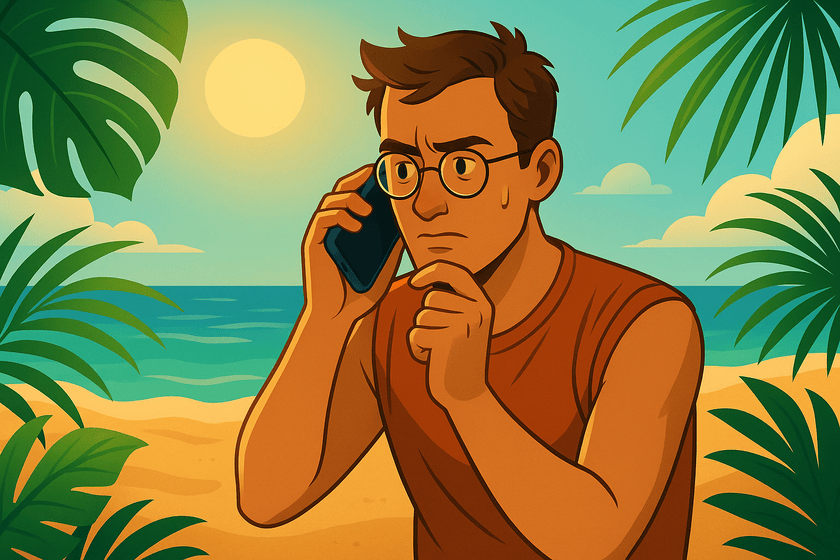

(*AI-generated image*)

### Zadanie
Twoim celem będzie stworzenie asystenta RAG - Retrival Augmented Generation na podstawie kilku plików PDF z artykułami naukowymi na wybrany przez siebie temat (3-5 artykułów).
### Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:
- Czy model poprawnie odpowiada na pytania ?
- Jakie są etapy przetwarzania dokumentu tekstowego ?
- Jaki wynik jest "dobry" ?
- Co robi mój asystent AI ? Jak on działa ? Jak tworzona jest odpowiedź ?
- Czy model poprawnie wybiera fragment dokumentu ? Czy poprawnie korzysta z bazy ?
- Jaką rolę w naszym systemie pełni baza wektorowa ?

### Wymagania
- Przygotuj artykuły naukowe i umieść je w folderze na dysku
- Stwórz wektorową bazę danych (można użyć innego systemu niż FAISS)
- Zapełnij bazę embeddingami z modelu wybranego przez Ciebie z [Sentence Similarity Models](https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=trending) z HuggingFace Hub - innego niż podany w notebooku wzorcowym
- Zainicjuj wybrany model QA z dostępnych [Question Answering Models](https://huggingface.co/models?pipeline_tag=question-answering&sort=trending) z HuggingFace Hub - również innego niż w notebooku wzorcowym
- Stwórz chaina odpowiadania na pytania i dodaj mechanizm pętli - tak, żeby można było przeprowadzać swobodną rozmowę z asystentem

**Dodatkowe wymagania**
- Mechanizm pamięci konwersacji - tak, żeby model pamiętał poprzednią część konwersacji
- Mechanizm braku halucynacji (bez cyberpsychozy) - jeśli model nie znajdzie odpowiedzi w bazie, informuje o tym
- Cytowanie dokumentu, z którego model pobrał informacje

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza Markdown.






# **Wczytywanie tesktu i podział na chunki**

In [5]:
pdf_folder_path = '/content/drive/My Drive/projekt_nlp/'
pdf_files = [os.path.join(pdf_folder_path, f) for f in os.listdir(pdf_folder_path) if f.endswith('.pdf')]

# Wczytanie wszystkich dokumentów
all_pages = []
for path in pdf_files:
    loader = PyPDFLoader(path)
    pages = loader.load()
    all_pages.extend(pages)

print(f"Wczytano łącznie {len(all_pages)} stron z {len(pdf_files)} dokumentów.")
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=150,
    length_function=len
)
docs = text_splitter.split_documents(all_pages)

print(f"Podzielono dokumenty na {len(docs)} fragmentów.")

Wczytano łącznie 114 stron z 5 dokumentów.
Podzielono dokumenty na 473 fragmentów.


# **Tworzenia Embeddingów**

In [6]:
model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
embeddings = HuggingFaceEmbeddings(model_name=model_name)
db = FAISS.from_documents(docs, embeddings)

# Zapisanie bazy lokalnie, aby nie trzeba było jej tworzyć za każdym razem
db.save_local("faiss_index_projekt")

print("Baza wektorowa została stworzona i zapisana.")

/tmp/ipython-input-2193062760.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=model_name)


Baza wektorowa została stworzona i zapisana.


# **Załadwoanie modelu**

In [7]:
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig

notebook_login()
llm_model_name = "mistralai/Mistral-7B-Instruct-v0.3"

#  konfiguracja kwantyzacji
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_enable_fp32_cpu_offload=True
)

tokenizer = AutoTokenizer.from_pretrained(llm_model_name)

model = AutoModelForCausalLM.from_pretrained(
    llm_model_name,
    trust_remote_code=True,
    quantization_config=quantization_config,
    device_map="auto"
)



pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    max_new_tokens=1024,
    repetition_penalty=1.15
)


llm = HuggingFacePipeline(pipeline=pipe)


memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)
qa_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(),
    memory=memory
)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0
/tmp/ipython-input-502745449.py:37: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=pipe)
/tmp/ipython-input-502745449.py:40: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(


In [8]:
print("Asystent AI gotowy. Wpisz 'koniec', aby zakończyć rozmowę.")
print("-" * 50)

while True:
    query = input("Ty: ")
    if query.lower() == 'koniec':
        print("Asystent AI: Do zobaczenia!")
        break
    result = qa_chain.invoke({"question": query})
    answer = result['answer']
    if "nie mam informacji" in answer.lower() or "nie wiem" in answer.lower():
        print("Asystent AI: Przepraszam, ale nie znalazłem odpowiedzi na to pytanie w dostarczonych dokumentach.")
    else:
        print(f"Asystent AI: {answer}")
        source_documents = result.get('source_documents')
        if source_documents:
            # lista unikalnych źródeł
            unique_sources = set([doc.metadata['source'] for doc in source_documents if hasattr(doc, 'metadata') and 'source' in doc.metadata])
            if unique_sources:
                print(f"Źródła: {', '.join(unique_sources)}")
    print("-" * 50)

Asystent AI gotowy. Wpisz 'koniec', aby zakończyć rozmowę.
--------------------------------------------------
Ty: What does the author mean by the "grammar of schooling," and why does he argue for its end?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Asystent AI: Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Tyack, D. B., & Cuban, L. (1995).Tinkering toward utopia: A century of public school reform. Harvard
University Press.
Tyack, D., & Tobin, W. (1994). The“grammar” of schooling: Why has it been so hard to change?American
Educational Research Journal, 31(3), 453–479. https://doi.org/10.3102/00028312031003453
Valant, J., & Newark, D. A. (2016). The politics of achievement gaps: U.S. Public opinion on race-based and
wealth-based differences in test scores.Educational Researcher, XX(X), 1–16. https://doi.org/10.3102/
0013189X16658447
Wagner, T. (2008).The global achievement gap: Why even our best schools don’t teach the new survival skills
our children need–and what we can do about it. Basic Books.
Wagner, T. (2012).Creating innovators: The making of young people who will change the world. Scribner.
Warren, A. (2016)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Asystent AI: Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Tyack, D. B., & Cuban, L. (1995).Tinkering toward utopia: A century of public school reform. Harvard
University Press.
Tyack, D., & Tobin, W. (1994). The“grammar” of schooling: Why has it been so hard to change?American
Educational Research Journal, 31(3), 453–479. https://doi.org/10.3102/00028312031003453
Valant, J., & Newark, D. A. (2016). The politics of achievement gaps: U.S. Public opinion on race-based and
wealth-based differences in test scores.Educational Researcher, XX(X), 1–16. https://doi.org/10.3102/
0013189X16658447
Wagner, T. (2008).The global achievement gap: Why even our best schools don’t teach the new survival skills
our children need–and what we can do about it. Basic Books.
Wagner, T. (2012).Creating innovators: The making of young people who will change the world. Scribner.
Warren, A. (2016)

## Tajemniczy zleceniodawca

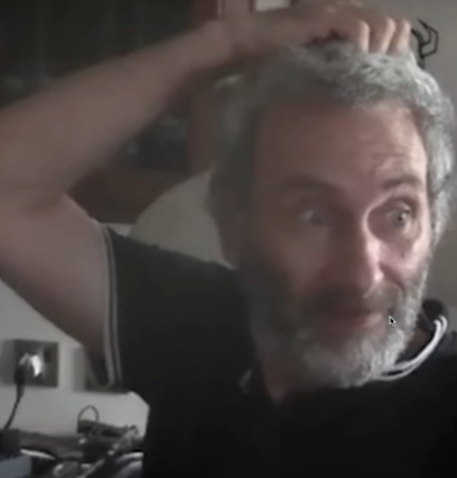